# Model building and evaluation 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
from sklearn.metrics import auc
import supervision as sv
from supervision.metrics import MeanAveragePrecision
from ultralytics import YOLO

%matplotlib inline

In [2]:
IMAGE_PATH = 'image_chips_native'
LABEL_PATH = 'labels/labels_native'
PATH = os.getcwd()

images = os.listdir(IMAGE_PATH)
labels = os.listdir(LABEL_PATH)

print(f'Image counts: {len(images)}')
print(f'Label counts: {len(labels)}')

label_files = os.listdir(LABEL_PATH)

for label_file in label_files:
    label_path = os.path.join(LABEL_PATH, label_file)

    with open(label_path, 'r') as file:
        lines = file.readlines()

    updated_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            parts[0] = '0'
            updated_lines.append(" ".join(parts))
    
    with open(label_path, 'w') as file:
        file.write("\n".join(updated_lines) + "\n")

print("All label categories have been set to 0.")

Image counts: 2542
Label counts: 2542
All label categories have been set to 0.


## Split the data into 80-20 train-test split. Use 10% of training data as validation.

In [3]:
images = sorted([img for img in os.listdir(IMAGE_PATH) if img.endswith('.tif')])
print(f"Total images after cleaning: {len(images)}")

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

total_cnt = len(images)
train_cnt = int(TRAIN_SPLIT * total_cnt)
train_images = images[:train_cnt]
test_images = images[train_cnt:]

n_val = int(VAL_SPLIT * len(train_images))
val_images = random.sample(train_images, n_val)
train_final = [img for img in train_images if img not in val_images]

print(f'Train: {len(train_final)}; Val: {len(val_images)}; Test: {len(test_images)}')

Total images after cleaning: 2542
Train: 1830; Val: 203; Test: 509


In [4]:
DATA = os.path.join(PATH, "data")

for split in ["train", "val", "test"]:
    for sub in ["images", "labels"]:
        os.makedirs(os.path.join(DATA, split, sub), exist_ok=True)

def copy_files(file_list, split):
    for file in file_list:
        src_img = os.path.join(IMAGE_PATH, file)
        dst_img = os.path.join(DATA, split, "images", file)
        shutil.copy(src_img, dst_img)
        
        label_file = file[:-4] + ".txt"
        src_label = os.path.join(LABEL_PATH, label_file)
        dst_label = os.path.join(DATA, split, "labels", label_file)
        shutil.copy(src_label, dst_label)

copy_files(train_final, "train")
copy_files(val_images, "val")
copy_files(test_images, "test")

## 1. Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged. 

In [5]:
model = YOLO("yolo11n.pt")

results = model.train(
    data='dataset.yaml', 
    epochs=300, 
    imgsz=416,
    batch=16,
    nms=True,
    single_cls=True,
    verbose=False,
    workers=32,
    dropout=0.3,
)

model = YOLO("runs/detect/train/weights/best.pt")

New https://pypi.org/project/ultralytics/8.3.86 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.80 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7933MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=dataset.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=32, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

train: Scanning /home/nishuz/Desktop/College/SRIP/Selection/data/train/labels... 1830 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1830/1830 [00:01<00:00, 1489.11it/s]


train: New cache created: /home/nishuz/Desktop/College/SRIP/Selection/data/train/labels.cache


val: Scanning /home/nishuz/Desktop/College/SRIP/Selection/data/val/labels... 203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 203/203 [00:00<00:00, 835.29it/s]

val: New cache created: /home/nishuz/Desktop/College/SRIP/Selection/data/val/labels.cache


Plotting labels to /home/nishuz/Desktop/College/SRIP/Selection/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 32 dataloader workers
Logging results to /home/nishuz/Desktop/College/SRIP/Selection/runs/detect/train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.27G      1.962        2.2      1.366        153        416: 100%|██████████| 115/115 [00:09<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.50it/s]

                   all        203       2306       0.72      0.549      0.641      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.49G      1.594       1.21      1.172        144        416: 100%|██████████| 115/115 [00:09<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]

                   all        203       2306      0.697      0.614      0.683        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.43G      1.503      1.089      1.131        167        416: 100%|██████████| 115/115 [00:08<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.79it/s]

                   all        203       2306      0.701      0.592      0.653      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.45G      1.436      1.013      1.113        113        416: 100%|██████████| 115/115 [00:08<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.81it/s]


                   all        203       2306       0.63      0.614      0.609      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.47G      1.394     0.9714      1.098        163        416: 100%|██████████| 115/115 [00:08<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.41it/s]

                   all        203       2306      0.797      0.667      0.745      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.31G      1.385     0.9493       1.09        212        416: 100%|██████████| 115/115 [00:07<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]

                   all        203       2306      0.792      0.714      0.791      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.31G      1.359     0.9133      1.073        111        416: 100%|██████████| 115/115 [00:08<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.26it/s]

                   all        203       2306      0.768      0.739      0.791      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      1.36G      1.316     0.8737      1.056         69        416: 100%|██████████| 115/115 [00:08<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.48it/s]

                   all        203       2306      0.807      0.757      0.826       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300       1.4G      1.308     0.8594      1.049         36        416: 100%|██████████| 115/115 [00:06<00:00, 17.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.55it/s]

                   all        203       2306      0.785      0.745      0.799      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      1.26G      1.267      0.827      1.036         75        416: 100%|██████████| 115/115 [00:06<00:00, 17.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.71it/s]


                   all        203       2306      0.763      0.734      0.787      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.44G       1.28     0.8354      1.043         86        416: 100%|██████████| 115/115 [00:07<00:00, 15.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.73it/s]

                   all        203       2306      0.825       0.77      0.849      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300       1.3G      1.257     0.8155      1.038        111        416: 100%|██████████| 115/115 [00:06<00:00, 17.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]

                   all        203       2306       0.86      0.803      0.886      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      1.46G      1.244     0.7967      1.028        106        416: 100%|██████████| 115/115 [00:06<00:00, 16.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.41it/s]

                   all        203       2306      0.847      0.782      0.867      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.47G      1.241     0.7943       1.02         87        416: 100%|██████████| 115/115 [00:07<00:00, 14.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.80it/s]

                   all        203       2306      0.839      0.779      0.859      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300       1.4G      1.198     0.7615      1.006        128        416: 100%|██████████| 115/115 [00:06<00:00, 16.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.69it/s]

                   all        203       2306      0.813      0.766      0.839      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      1.37G      1.214     0.7694      1.016        116        416: 100%|██████████| 115/115 [00:07<00:00, 16.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.21it/s]

                   all        203       2306      0.854       0.83      0.888      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      1.37G      1.191     0.7495       1.01        146        416: 100%|██████████| 115/115 [00:07<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.07it/s]

                   all        203       2306      0.867       0.79      0.869      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      1.52G      1.205     0.7551      1.011        158        416: 100%|██████████| 115/115 [00:07<00:00, 15.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]

                   all        203       2306      0.863      0.817      0.885       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.56G      1.177     0.7452      1.005        173        416: 100%|██████████| 115/115 [00:06<00:00, 16.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]

                   all        203       2306      0.825      0.799      0.853      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      1.48G      1.174     0.7397          1         53        416: 100%|██████████| 115/115 [00:07<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.12it/s]

                   all        203       2306      0.861       0.81       0.89      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      1.62G      1.173     0.7304     0.9973        163        416: 100%|██████████| 115/115 [00:07<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.91it/s]

                   all        203       2306      0.893        0.8      0.896      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      1.46G      1.163     0.7204     0.9923        136        416: 100%|██████████| 115/115 [00:07<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.73it/s]

                   all        203       2306      0.885      0.814      0.904      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.44G      1.174       0.72     0.9944         64        416: 100%|██████████| 115/115 [00:07<00:00, 15.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.10it/s]

                   all        203       2306      0.876      0.838        0.9      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      1.44G      1.197     0.7371     0.9993        108        416: 100%|██████████| 115/115 [00:08<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.63it/s]

                   all        203       2306      0.882      0.817      0.897      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      1.33G      1.126     0.7017     0.9886        154        416: 100%|██████████| 115/115 [00:08<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.46it/s]

                   all        203       2306      0.875      0.843      0.905      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      1.44G      1.127     0.7036     0.9829         72        416: 100%|██████████| 115/115 [00:08<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.17it/s]

                   all        203       2306      0.861      0.824        0.9      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300       1.4G      1.126     0.6935     0.9804        190        416: 100%|██████████| 115/115 [00:06<00:00, 16.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.38it/s]

                   all        203       2306      0.854      0.827      0.889      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      1.41G      1.108     0.6835     0.9795         58        416: 100%|██████████| 115/115 [00:08<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.22it/s]

                   all        203       2306      0.887      0.825      0.908      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300       1.5G      1.105     0.6808     0.9729        179        416: 100%|██████████| 115/115 [00:08<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.61it/s]

                   all        203       2306        0.9       0.81      0.908      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      1.47G      1.115     0.6825     0.9774         90        416: 100%|██████████| 115/115 [00:07<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]

                   all        203       2306      0.893      0.851      0.915      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300       1.4G      1.106     0.6866     0.9781        139        416: 100%|██████████| 115/115 [00:07<00:00, 15.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]

                   all        203       2306      0.861      0.813      0.887      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      1.46G      1.093     0.6678     0.9762         99        416: 100%|██████████| 115/115 [00:08<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.52it/s]

                   all        203       2306      0.882      0.847      0.913      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      1.41G      1.099     0.6699     0.9698        191        416: 100%|██████████| 115/115 [00:09<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]

                   all        203       2306      0.879      0.847      0.899      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      1.36G       1.08     0.6587     0.9642         81        416: 100%|██████████| 115/115 [00:08<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.73it/s]

                   all        203       2306      0.897      0.849      0.916       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      1.45G      1.083      0.659     0.9691        138        416: 100%|██████████| 115/115 [00:08<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.96it/s]

                   all        203       2306      0.899      0.835      0.915      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      1.23G      1.101     0.6703      0.969        115        416: 100%|██████████| 115/115 [00:08<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.37it/s]

                   all        203       2306      0.907      0.848      0.926      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      1.47G      1.059     0.6413     0.9501        105        416: 100%|██████████| 115/115 [00:08<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.18it/s]

                   all        203       2306      0.908      0.835       0.92       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300       1.4G      1.066     0.6444     0.9548        119        416: 100%|██████████| 115/115 [00:08<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]

                   all        203       2306      0.907      0.866      0.934      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300       1.3G      1.056     0.6484     0.9517        142        416: 100%|██████████| 115/115 [00:08<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.99it/s]

                   all        203       2306      0.903      0.861      0.928      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      1.56G      1.075     0.6533     0.9563        179        416: 100%|██████████| 115/115 [00:08<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]

                   all        203       2306      0.902      0.858      0.922      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      1.25G      1.051     0.6411      0.963        118        416: 100%|██████████| 115/115 [00:08<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.94it/s]

                   all        203       2306      0.915      0.858       0.93       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      1.33G       1.06     0.6442     0.9553         63        416: 100%|██████████| 115/115 [00:08<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.88it/s]

                   all        203       2306      0.894      0.831      0.909      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      1.31G      1.032     0.6361     0.9573        100        416: 100%|██████████| 115/115 [00:07<00:00, 15.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.60it/s]

                   all        203       2306      0.895      0.865      0.927      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300       1.4G      1.035     0.6236     0.9462        144        416: 100%|██████████| 115/115 [00:07<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.22it/s]

                   all        203       2306      0.917       0.85      0.929      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      1.54G      1.026     0.6223     0.9463        144        416: 100%|██████████| 115/115 [00:08<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.52it/s]

                   all        203       2306      0.886      0.851      0.926      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      1.49G      1.038      0.631     0.9548         40        416: 100%|██████████| 115/115 [00:08<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.40it/s]

                   all        203       2306      0.909      0.873      0.935      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      1.63G      1.041      0.638     0.9521        105        416: 100%|██████████| 115/115 [00:07<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.26it/s]

                   all        203       2306      0.879      0.842      0.912      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      1.42G      1.025     0.6244      0.946         71        416: 100%|██████████| 115/115 [00:08<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]

                   all        203       2306      0.891      0.861      0.923      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      1.34G      1.017     0.6192      0.947         40        416: 100%|██████████| 115/115 [00:07<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.77it/s]

                   all        203       2306       0.92      0.877      0.938      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300       1.5G      1.025     0.6203     0.9461         95        416: 100%|██████████| 115/115 [00:08<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.32it/s]

                   all        203       2306      0.923      0.879      0.941      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      1.36G      1.001     0.6089     0.9387        137        416: 100%|██████████| 115/115 [00:08<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.66it/s]

                   all        203       2306      0.913       0.89      0.937      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      1.57G     0.9987     0.6089      0.943        110        416: 100%|██████████| 115/115 [00:08<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.81it/s]

                   all        203       2306      0.919       0.86      0.935      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      1.43G      1.001     0.6087     0.9478        290        416: 100%|██████████| 115/115 [00:07<00:00, 16.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.09it/s]


                   all        203       2306      0.916       0.88       0.94      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300       1.3G     0.9982     0.6026     0.9388         79        416: 100%|██████████| 115/115 [00:07<00:00, 16.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]

                   all        203       2306      0.934      0.859      0.942      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300       1.6G     0.9951      0.606      0.944        119        416: 100%|██████████| 115/115 [00:07<00:00, 15.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.10it/s]

                   all        203       2306      0.917      0.877       0.94      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      1.52G      1.007     0.6086      0.946        112        416: 100%|██████████| 115/115 [00:07<00:00, 15.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.05it/s]

                   all        203       2306      0.912      0.864      0.929      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      1.39G     0.9947     0.6043     0.9389        124        416: 100%|██████████| 115/115 [00:07<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.27it/s]

                   all        203       2306      0.924      0.873      0.941      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300       1.4G     0.9995     0.6016     0.9338        164        416: 100%|██████████| 115/115 [00:08<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.45it/s]


                   all        203       2306      0.903      0.891       0.94      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300       1.5G     0.9907     0.5961     0.9328         61        416: 100%|██████████| 115/115 [00:08<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.84it/s]

                   all        203       2306      0.932      0.864      0.939      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      1.47G     0.9797      0.589     0.9364         56        416: 100%|██████████| 115/115 [00:08<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.13it/s]

                   all        203       2306      0.927      0.898      0.945      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      1.45G     0.9746     0.5825     0.9325        122        416: 100%|██████████| 115/115 [00:08<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]

                   all        203       2306      0.929      0.874      0.948      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      1.41G     0.9756     0.5871     0.9363         70        416: 100%|██████████| 115/115 [00:07<00:00, 15.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]

                   all        203       2306      0.919      0.881      0.942      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      1.62G     0.9669     0.5852      0.934         89        416: 100%|██████████| 115/115 [00:08<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]

                   all        203       2306      0.918      0.892      0.936      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      1.56G     0.9749      0.586     0.9331        113        416: 100%|██████████| 115/115 [00:08<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

                   all        203       2306      0.926      0.882      0.947       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300       1.3G     0.9708     0.5874     0.9336         74        416: 100%|██████████| 115/115 [00:07<00:00, 16.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]

                   all        203       2306      0.934      0.893      0.949      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      1.48G     0.9652     0.5768     0.9276        149        416: 100%|██████████| 115/115 [00:07<00:00, 15.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.41it/s]

                   all        203       2306      0.924      0.892      0.953      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      1.33G     0.9511     0.5765     0.9274        107        416: 100%|██████████| 115/115 [00:07<00:00, 15.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]

                   all        203       2306      0.943      0.879      0.951      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      1.48G     0.9354     0.5678     0.9218         47        416: 100%|██████████| 115/115 [00:07<00:00, 15.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.23it/s]


                   all        203       2306      0.932      0.896      0.952      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      1.55G     0.9403     0.5648     0.9281         86        416: 100%|██████████| 115/115 [00:08<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.12it/s]

                   all        203       2306      0.937      0.889      0.948      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300       1.2G     0.9586     0.5803     0.9297        118        416: 100%|██████████| 115/115 [00:06<00:00, 16.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.29it/s]

                   all        203       2306      0.933      0.893      0.947      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      1.57G     0.9634     0.5878     0.9285         33        416: 100%|██████████| 115/115 [00:08<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.96it/s]

                   all        203       2306       0.92      0.889      0.946      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      1.48G     0.9569     0.5746     0.9255         83        416: 100%|██████████| 115/115 [00:08<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.03it/s]

                   all        203       2306      0.915      0.895      0.946      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      1.51G     0.9459     0.5741     0.9225        158        416: 100%|██████████| 115/115 [00:07<00:00, 15.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.63it/s]

                   all        203       2306      0.941      0.892      0.954      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      1.57G     0.9408     0.5707     0.9212         71        416: 100%|██████████| 115/115 [00:07<00:00, 16.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]

                   all        203       2306      0.931      0.898      0.951      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      1.46G     0.9464     0.5682     0.9194         69        416: 100%|██████████| 115/115 [00:07<00:00, 15.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all        203       2306      0.932      0.898      0.953      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      1.43G     0.9313     0.5612     0.9216         44        416: 100%|██████████| 115/115 [00:08<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.71it/s]

                   all        203       2306      0.933      0.892      0.951      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      1.65G     0.9389     0.5642     0.9247        157        416: 100%|██████████| 115/115 [00:06<00:00, 17.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.85it/s]

                   all        203       2306      0.931      0.888      0.951      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      1.63G     0.9354     0.5669     0.9197        140        416: 100%|██████████| 115/115 [00:07<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.52it/s]

                   all        203       2306      0.945      0.887      0.955       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      1.54G     0.9156     0.5545     0.9189        119        416: 100%|██████████| 115/115 [00:08<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.91it/s]

                   all        203       2306      0.945      0.885      0.954      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      1.55G     0.9161     0.5526     0.9221         39        416: 100%|██████████| 115/115 [00:07<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.95it/s]

                   all        203       2306      0.936      0.892      0.952      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      1.54G     0.9144     0.5493     0.9159         87        416: 100%|██████████| 115/115 [00:06<00:00, 18.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.97it/s]

                   all        203       2306      0.932      0.898      0.948      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      1.39G     0.9235     0.5571     0.9202         91        416: 100%|██████████| 115/115 [00:07<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]

                   all        203       2306      0.938      0.896      0.954      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      1.61G     0.9222     0.5601     0.9215         77        416: 100%|██████████| 115/115 [00:07<00:00, 15.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.44it/s]


                   all        203       2306      0.929      0.886       0.95      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300       1.4G     0.9304     0.5578     0.9224         86        416: 100%|██████████| 115/115 [00:07<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.44it/s]

                   all        203       2306      0.939       0.91      0.956      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      1.54G     0.9238     0.5512     0.9185        121        416: 100%|██████████| 115/115 [00:06<00:00, 17.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.22it/s]

                   all        203       2306      0.937      0.903      0.955       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      1.49G     0.9181     0.5493     0.9184         63        416: 100%|██████████| 115/115 [00:06<00:00, 17.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.44it/s]

                   all        203       2306       0.94      0.903      0.958      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      1.38G     0.9188     0.5521     0.9223        147        416: 100%|██████████| 115/115 [00:07<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.60it/s]

                   all        203       2306      0.936      0.903      0.958      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      1.38G     0.9111     0.5499     0.9167        178        416: 100%|██████████| 115/115 [00:07<00:00, 16.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]

                   all        203       2306      0.941      0.887      0.956      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300       1.4G     0.9192     0.5528     0.9201        290        416: 100%|██████████| 115/115 [00:07<00:00, 15.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]

                   all        203       2306      0.936      0.899      0.956      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      1.76G     0.9227     0.5574     0.9172        132        416: 100%|██████████| 115/115 [00:06<00:00, 17.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.45it/s]


                   all        203       2306      0.951      0.891      0.955      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      1.49G     0.8969     0.5419      0.917         71        416: 100%|██████████| 115/115 [00:06<00:00, 18.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.69it/s]

                   all        203       2306      0.948      0.897      0.957      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      1.62G     0.8873     0.5374     0.9152        111        416: 100%|██████████| 115/115 [00:07<00:00, 15.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.52it/s]

                   all        203       2306      0.948      0.893      0.957      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      1.42G     0.9039      0.549     0.9148        145        416: 100%|██████████| 115/115 [00:07<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]

                   all        203       2306      0.922      0.892      0.948      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      1.41G     0.8955     0.5396     0.9122        105        416: 100%|██████████| 115/115 [00:07<00:00, 15.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]

                   all        203       2306      0.936      0.905      0.959      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      1.42G     0.8846     0.5325     0.9125        174        416: 100%|██████████| 115/115 [00:08<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.35it/s]

                   all        203       2306      0.946      0.897      0.959      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      1.41G     0.8832     0.5324      0.908         47        416: 100%|██████████| 115/115 [00:08<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.60it/s]

                   all        203       2306      0.943      0.895      0.956      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      1.54G     0.8881     0.5355     0.9064         96        416: 100%|██████████| 115/115 [00:07<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.69it/s]

                   all        203       2306      0.947      0.905      0.959      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      1.67G     0.8691     0.5265     0.9044        101        416: 100%|██████████| 115/115 [00:08<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.78it/s]

                   all        203       2306      0.943      0.912      0.959      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      1.44G     0.8998     0.5412     0.9086         57        416: 100%|██████████| 115/115 [00:08<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.66it/s]

                   all        203       2306      0.928      0.902       0.95      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      1.45G     0.8974      0.539     0.9119        150        416: 100%|██████████| 115/115 [00:08<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.98it/s]

                   all        203       2306      0.938      0.915       0.96       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      1.42G     0.8642     0.5227     0.9054        111        416: 100%|██████████| 115/115 [00:07<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.36it/s]

                   all        203       2306      0.931      0.907      0.957      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      1.45G     0.8794     0.5313     0.9132         96        416: 100%|██████████| 115/115 [00:08<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]

                   all        203       2306       0.94      0.915       0.96      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      1.58G     0.8822     0.5292     0.9052         63        416: 100%|██████████| 115/115 [00:08<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.53it/s]

                   all        203       2306      0.949      0.902      0.957      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300       1.4G     0.8719     0.5231     0.9071        109        416: 100%|██████████| 115/115 [00:08<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.04it/s]

                   all        203       2306      0.954      0.899      0.962      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      1.37G     0.8615     0.5252     0.9042         92        416: 100%|██████████| 115/115 [00:08<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.01it/s]

                   all        203       2306      0.939      0.915      0.963      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300       1.3G     0.8762     0.5288     0.9059         85        416: 100%|██████████| 115/115 [00:08<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.89it/s]

                   all        203       2306      0.945      0.904       0.96      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      1.48G     0.8806     0.5335     0.9107        119        416: 100%|██████████| 115/115 [00:08<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.93it/s]

                   all        203       2306      0.943      0.911      0.959      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300       1.5G     0.8588     0.5229     0.9028        146        416: 100%|██████████| 115/115 [00:08<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.37it/s]

                   all        203       2306       0.94      0.918      0.962      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      1.48G     0.8698     0.5254     0.9021         78        416: 100%|██████████| 115/115 [00:09<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.48it/s]

                   all        203       2306      0.938      0.915      0.962      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      1.54G      0.853     0.5167     0.9021        139        416: 100%|██████████| 115/115 [00:09<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]

                   all        203       2306      0.942      0.917      0.962      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300       1.5G     0.8469     0.5158     0.8967         79        416: 100%|██████████| 115/115 [00:08<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.51it/s]

                   all        203       2306      0.943      0.924      0.965      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300       1.4G     0.8345     0.5072     0.9004        179        416: 100%|██████████| 115/115 [00:08<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.12it/s]


                   all        203       2306      0.955      0.903      0.962      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300       1.5G     0.8604     0.5226     0.9019        116        416: 100%|██████████| 115/115 [00:08<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.41it/s]

                   all        203       2306      0.958      0.911      0.966      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300       1.3G     0.8345     0.5054     0.8992        112        416: 100%|██████████| 115/115 [00:07<00:00, 15.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.88it/s]

                   all        203       2306      0.941      0.924      0.965      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      1.39G     0.8484     0.5158     0.9021        160        416: 100%|██████████| 115/115 [00:07<00:00, 16.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.63it/s]

                   all        203       2306      0.947      0.915      0.965      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      1.49G     0.8375     0.5068     0.8991        163        416: 100%|██████████| 115/115 [00:07<00:00, 15.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.39it/s]

                   all        203       2306       0.95      0.913      0.964       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      1.45G     0.8538     0.5144     0.8997        117        416: 100%|██████████| 115/115 [00:08<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.71it/s]

                   all        203       2306      0.946       0.92      0.965      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      1.48G      0.842       0.51     0.8962        139        416: 100%|██████████| 115/115 [00:07<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.58it/s]

                   all        203       2306      0.953      0.905      0.963      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      1.71G     0.8566     0.5167     0.8978        182        416: 100%|██████████| 115/115 [00:07<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.00it/s]

                   all        203       2306      0.946        0.9      0.961      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      1.49G     0.8271     0.5029     0.8958        168        416: 100%|██████████| 115/115 [00:08<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]

                   all        203       2306      0.951      0.914      0.967      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      1.48G      0.847     0.5127     0.9002        134        416: 100%|██████████| 115/115 [00:06<00:00, 18.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.70it/s]

                   all        203       2306      0.941      0.917      0.965      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      1.28G     0.8389     0.5075     0.8986        233        416: 100%|██████████| 115/115 [00:07<00:00, 16.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.78it/s]

                   all        203       2306      0.945      0.915      0.965      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300       1.4G     0.8205        0.5     0.8917        189        416: 100%|██████████| 115/115 [00:06<00:00, 17.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.15it/s]

                   all        203       2306      0.946      0.919      0.965       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      1.37G     0.8436     0.5105     0.8952        128        416: 100%|██████████| 115/115 [00:07<00:00, 15.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.65it/s]

                   all        203       2306      0.943      0.919      0.961      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      1.37G     0.8325     0.5021     0.8949        141        416: 100%|██████████| 115/115 [00:07<00:00, 16.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]

                   all        203       2306      0.945      0.921      0.968      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      1.32G     0.8377     0.5074     0.8961         72        416: 100%|██████████| 115/115 [00:06<00:00, 17.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.15it/s]


                   all        203       2306      0.939      0.935       0.97      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      1.37G     0.8191     0.4982     0.8913        171        416: 100%|██████████| 115/115 [00:07<00:00, 15.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.30it/s]

                   all        203       2306      0.942      0.925      0.966      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      1.51G      0.819     0.4957     0.8929        101        416: 100%|██████████| 115/115 [00:07<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.17it/s]

                   all        203       2306      0.946      0.914      0.964      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      1.49G     0.8155      0.493     0.8882        105        416: 100%|██████████| 115/115 [00:08<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]

                   all        203       2306      0.948      0.925      0.967      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      1.44G     0.8363     0.5039     0.8933         93        416: 100%|██████████| 115/115 [00:07<00:00, 15.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.97it/s]

                   all        203       2306      0.947      0.915      0.965      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      1.64G     0.8077      0.496     0.8928         53        416: 100%|██████████| 115/115 [00:07<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]

                   all        203       2306       0.95      0.923      0.969      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      1.46G     0.8146     0.4957     0.8968         61        416: 100%|██████████| 115/115 [00:08<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]

                   all        203       2306      0.957      0.912      0.966      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      1.35G     0.8142     0.4965      0.889         83        416: 100%|██████████| 115/115 [00:07<00:00, 15.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.55it/s]

                   all        203       2306      0.951      0.926      0.968       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300       1.5G     0.8197      0.498     0.8908         75        416: 100%|██████████| 115/115 [00:07<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.29it/s]


                   all        203       2306      0.943      0.924      0.968      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      1.39G     0.8101     0.4934     0.8864        138        416: 100%|██████████| 115/115 [00:07<00:00, 15.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.26it/s]

                   all        203       2306      0.957      0.918       0.97      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      1.48G     0.8024     0.4912     0.8875         37        416: 100%|██████████| 115/115 [00:06<00:00, 17.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.56it/s]

                   all        203       2306      0.959      0.924      0.969       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      1.44G     0.8185     0.4971     0.8904         88        416: 100%|██████████| 115/115 [00:07<00:00, 15.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.45it/s]

                   all        203       2306      0.954      0.921      0.969       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      1.27G     0.8119     0.4942     0.8923         75        416: 100%|██████████| 115/115 [00:07<00:00, 15.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.82it/s]

                   all        203       2306      0.957      0.915      0.969       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      1.76G     0.8135     0.4938     0.8892         89        416: 100%|██████████| 115/115 [00:06<00:00, 17.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.41it/s]

                   all        203       2306      0.942      0.928      0.968      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      1.28G     0.8077     0.4936     0.8925         89        416: 100%|██████████| 115/115 [00:07<00:00, 15.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.26it/s]

                   all        203       2306      0.954      0.922      0.966      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      1.36G     0.8114     0.4926     0.8923         45        416: 100%|██████████| 115/115 [00:07<00:00, 15.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.30it/s]

                   all        203       2306      0.966      0.912      0.968       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      1.44G     0.7906     0.4824     0.8853        140        416: 100%|██████████| 115/115 [00:07<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.71it/s]


                   all        203       2306      0.957      0.926      0.971      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300       1.5G     0.8025     0.4926     0.8907        136        416: 100%|██████████| 115/115 [00:08<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.01it/s]

                   all        203       2306      0.951      0.928      0.969      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300       1.4G     0.8063     0.4943     0.8912         84        416: 100%|██████████| 115/115 [00:08<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.36it/s]

                   all        203       2306      0.955      0.924      0.969      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      1.55G       0.78     0.4778     0.8843         92        416: 100%|██████████| 115/115 [00:09<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.67it/s]

                   all        203       2306      0.954      0.924      0.969      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      1.21G     0.7932     0.4828     0.8857        119        416: 100%|██████████| 115/115 [00:08<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.96it/s]

                   all        203       2306      0.957      0.927       0.97      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      1.33G     0.7871     0.4829     0.8865        108        416: 100%|██████████| 115/115 [00:07<00:00, 15.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.99it/s]

                   all        203       2306      0.957      0.926      0.969      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      1.61G     0.7896     0.4844     0.8881         67        416: 100%|██████████| 115/115 [00:08<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]

                   all        203       2306      0.958       0.92      0.969      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      1.49G     0.7741     0.4741     0.8851         94        416: 100%|██████████| 115/115 [00:08<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.22it/s]

                   all        203       2306      0.957      0.917      0.968      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      1.52G     0.8028      0.488     0.8933        285        416: 100%|██████████| 115/115 [00:07<00:00, 14.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.21it/s]

                   all        203       2306       0.95      0.926       0.97      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      1.37G     0.8011     0.4884     0.8854        114        416: 100%|██████████| 115/115 [00:07<00:00, 14.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.53it/s]

                   all        203       2306      0.949      0.932      0.968      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      1.55G     0.7957     0.4828     0.8856        153        416: 100%|██████████| 115/115 [00:08<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.85it/s]

                   all        203       2306      0.955      0.916       0.97      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      1.45G     0.7785     0.4795     0.8819         82        416: 100%|██████████| 115/115 [00:08<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.99it/s]

                   all        203       2306      0.958      0.923      0.969      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      1.43G     0.7807     0.4777     0.8828        105        416: 100%|██████████| 115/115 [00:06<00:00, 16.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.97it/s]

                   all        203       2306      0.966      0.918       0.97        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      1.31G     0.7991      0.488     0.8915         68        416: 100%|██████████| 115/115 [00:07<00:00, 15.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]

                   all        203       2306      0.957      0.922       0.97      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300       1.3G     0.7966     0.4889     0.8874        122        416: 100%|██████████| 115/115 [00:07<00:00, 16.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.29it/s]

                   all        203       2306      0.951      0.927       0.97        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300       1.6G     0.7954     0.4831     0.8856         90        416: 100%|██████████| 115/115 [00:06<00:00, 17.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.65it/s]

                   all        203       2306      0.964      0.921       0.97      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      1.49G     0.7979     0.4835     0.8848         93        416: 100%|██████████| 115/115 [00:07<00:00, 16.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.64it/s]

                   all        203       2306      0.958      0.926      0.972      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      1.36G     0.7837     0.4772     0.8798         95        416: 100%|██████████| 115/115 [00:08<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]

                   all        203       2306      0.951      0.928      0.972      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      1.45G     0.7755      0.473     0.8879         64        416: 100%|██████████| 115/115 [00:07<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.28it/s]

                   all        203       2306      0.951       0.93      0.972      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      1.45G     0.7647     0.4696      0.879        144        416: 100%|██████████| 115/115 [00:07<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

                   all        203       2306       0.96      0.926      0.972      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      1.38G     0.7758     0.4739     0.8793        178        416: 100%|██████████| 115/115 [00:07<00:00, 16.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.51it/s]

                   all        203       2306      0.956      0.923      0.971        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      1.26G     0.7777     0.4729     0.8792        129        416: 100%|██████████| 115/115 [00:08<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.50it/s]

                   all        203       2306      0.964      0.927       0.97      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      1.46G       0.78      0.475     0.8829        176        416: 100%|██████████| 115/115 [00:06<00:00, 17.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.60it/s]

                   all        203       2306      0.967      0.923      0.972      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300       1.4G     0.7688     0.4723     0.8796         87        416: 100%|██████████| 115/115 [00:06<00:00, 18.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]

                   all        203       2306      0.959      0.925      0.972      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      1.41G      0.773     0.4762     0.8863         62        416: 100%|██████████| 115/115 [00:06<00:00, 18.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.67it/s]

                   all        203       2306      0.952      0.932       0.97      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      1.47G     0.7575     0.4654     0.8741        125        416: 100%|██████████| 115/115 [00:06<00:00, 18.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.52it/s]


                   all        203       2306      0.959      0.936      0.973      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      1.42G     0.7727     0.4716     0.8815         87        416: 100%|██████████| 115/115 [00:06<00:00, 18.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.26it/s]

                   all        203       2306      0.959      0.929      0.972      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      1.57G     0.7712     0.4719     0.8793        133        416: 100%|██████████| 115/115 [00:06<00:00, 18.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.12it/s]

                   all        203       2306      0.968      0.928      0.973      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      1.35G     0.7628     0.4717     0.8807        136        416: 100%|██████████| 115/115 [00:05<00:00, 19.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.40it/s]

                   all        203       2306      0.961      0.932      0.973      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      1.36G     0.7717     0.4719     0.8825         72        416: 100%|██████████| 115/115 [00:06<00:00, 18.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.46it/s]

                   all        203       2306      0.966      0.929      0.973      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      1.64G     0.7619     0.4716      0.881        157        416: 100%|██████████| 115/115 [00:06<00:00, 18.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.34it/s]

                   all        203       2306      0.958      0.928      0.968       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      1.46G     0.7619     0.4651     0.8814         47        416: 100%|██████████| 115/115 [00:08<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]

                   all        203       2306      0.957      0.934      0.973      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      1.36G      0.755      0.465     0.8801        134        416: 100%|██████████| 115/115 [00:08<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.50it/s]

                   all        203       2306      0.967       0.93      0.974      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      1.54G     0.7474     0.4602     0.8745        102        416: 100%|██████████| 115/115 [00:08<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]

                   all        203       2306      0.965      0.923      0.971      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      1.37G     0.7587     0.4671     0.8781         99        416: 100%|██████████| 115/115 [00:08<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.46it/s]

                   all        203       2306      0.963      0.928      0.972      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      1.47G     0.7471     0.4583     0.8753        136        416: 100%|██████████| 115/115 [00:08<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.75it/s]

                   all        203       2306      0.963       0.92      0.972      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      1.46G      0.745     0.4588     0.8768        166        416: 100%|██████████| 115/115 [00:08<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.45it/s]

                   all        203       2306       0.96      0.933      0.972      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      1.47G     0.7499     0.4622     0.8789        103        416: 100%|██████████| 115/115 [00:09<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.44it/s]

                   all        203       2306      0.957      0.936      0.972      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      1.56G     0.7587     0.4674     0.8791         95        416: 100%|██████████| 115/115 [00:08<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]

                   all        203       2306      0.962      0.928      0.973      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      1.36G     0.7455     0.4576     0.8743         88        416: 100%|██████████| 115/115 [00:08<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.73it/s]

                   all        203       2306      0.963       0.93      0.974      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      1.59G     0.7502     0.4626      0.876         93        416: 100%|██████████| 115/115 [00:08<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all        203       2306      0.962      0.926      0.972      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      1.45G     0.7461     0.4615     0.8795         77        416: 100%|██████████| 115/115 [00:08<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.41it/s]

                   all        203       2306      0.967      0.926      0.971      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      1.49G     0.7378     0.4552     0.8764        177        416: 100%|██████████| 115/115 [00:07<00:00, 15.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.18it/s]

                   all        203       2306      0.971      0.932      0.973      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      1.66G     0.7457     0.4637     0.8778         61        416: 100%|██████████| 115/115 [00:08<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.10it/s]

                   all        203       2306      0.964      0.937      0.973      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      1.38G     0.7555     0.4642     0.8802         81        416: 100%|██████████| 115/115 [00:08<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.61it/s]

                   all        203       2306      0.965      0.928      0.973      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      1.49G     0.7413     0.4561     0.8744        151        416: 100%|██████████| 115/115 [00:08<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.10it/s]

                   all        203       2306      0.964      0.936      0.972      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      1.37G     0.7479     0.4608     0.8784         63        416: 100%|██████████| 115/115 [00:08<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.23it/s]

                   all        203       2306      0.962      0.931      0.973      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      1.66G     0.7345     0.4546     0.8725         85        416: 100%|██████████| 115/115 [00:08<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.49it/s]

                   all        203       2306      0.962      0.936      0.973       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      1.34G     0.7395     0.4567      0.874        119        416: 100%|██████████| 115/115 [00:08<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]

                   all        203       2306      0.965      0.936      0.972      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      1.55G     0.7325      0.456     0.8729        122        416: 100%|██████████| 115/115 [00:08<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.42it/s]

                   all        203       2306      0.968      0.929      0.973      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      1.34G     0.7412     0.4565     0.8727        107        416: 100%|██████████| 115/115 [00:08<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.61it/s]

                   all        203       2306      0.966      0.932      0.974       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      1.24G     0.7341     0.4525     0.8739        147        416: 100%|██████████| 115/115 [00:08<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]

                   all        203       2306      0.961      0.941      0.975      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      1.66G     0.7481     0.4606     0.8768         62        416: 100%|██████████| 115/115 [00:07<00:00, 15.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.10it/s]

                   all        203       2306       0.96      0.938      0.974       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      1.55G     0.7348     0.4522      0.872        164        416: 100%|██████████| 115/115 [00:08<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]

                   all        203       2306      0.963      0.932      0.973      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      1.35G     0.7208     0.4468     0.8723        182        416: 100%|██████████| 115/115 [00:08<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.20it/s]

                   all        203       2306      0.972       0.93      0.973      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      1.34G     0.7161     0.4465     0.8696        111        416: 100%|██████████| 115/115 [00:08<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]

                   all        203       2306      0.963      0.938      0.976      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300       1.4G     0.7257     0.4484     0.8729         90        416: 100%|██████████| 115/115 [00:08<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.45it/s]

                   all        203       2306      0.969      0.925      0.973      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      1.61G     0.7421      0.457     0.8758         85        416: 100%|██████████| 115/115 [00:09<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.20it/s]

                   all        203       2306      0.959      0.937      0.974      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      1.38G     0.7273     0.4511     0.8725        100        416: 100%|██████████| 115/115 [00:08<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]

                   all        203       2306      0.965      0.929      0.972      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      1.47G     0.7299     0.4517     0.8761         42        416: 100%|██████████| 115/115 [00:09<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.20it/s]

                   all        203       2306      0.963      0.937      0.973      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      1.44G     0.7329     0.4513     0.8717        125        416: 100%|██████████| 115/115 [00:08<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.16it/s]

                   all        203       2306      0.961      0.942      0.973      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      1.35G     0.7444     0.4572     0.8734        134        416: 100%|██████████| 115/115 [00:09<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.65it/s]

                   all        203       2306      0.966      0.935      0.975      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      1.35G     0.7321     0.4544     0.8721        159        416: 100%|██████████| 115/115 [00:08<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.09it/s]

                   all        203       2306      0.964      0.931      0.974      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      1.43G     0.7291     0.4482     0.8713         78        416: 100%|██████████| 115/115 [00:08<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.70it/s]

                   all        203       2306      0.965      0.937      0.975      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      1.37G      0.716     0.4424     0.8721        183        416: 100%|██████████| 115/115 [00:08<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.51it/s]

                   all        203       2306      0.963      0.942      0.974      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      1.68G      0.728     0.4494     0.8711        117        416: 100%|██████████| 115/115 [00:08<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.34it/s]

                   all        203       2306      0.965      0.937      0.975      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300       1.5G     0.7198     0.4454     0.8685        136        416: 100%|██████████| 115/115 [00:08<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.70it/s]

                   all        203       2306      0.962      0.939      0.975      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      1.63G     0.7086     0.4427     0.8694         81        416: 100%|██████████| 115/115 [00:08<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.74it/s]

                   all        203       2306      0.965      0.939      0.976      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300       1.5G     0.7147     0.4453      0.871         95        416: 100%|██████████| 115/115 [00:07<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.99it/s]

                   all        203       2306      0.965       0.94      0.974      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      1.59G     0.7047     0.4366      0.866         70        416: 100%|██████████| 115/115 [00:08<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.37it/s]

                   all        203       2306      0.966      0.934      0.974      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      1.46G     0.7117     0.4415     0.8704        106        416: 100%|██████████| 115/115 [00:08<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.52it/s]

                   all        203       2306      0.962      0.941      0.977      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      1.56G     0.7049     0.4424     0.8691        101        416: 100%|██████████| 115/115 [00:08<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.29it/s]

                   all        203       2306       0.96      0.943      0.976       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      1.34G      0.707     0.4405     0.8695        133        416: 100%|██████████| 115/115 [00:08<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.46it/s]

                   all        203       2306      0.963      0.942      0.976      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      1.36G     0.7047     0.4393     0.8669         86        416: 100%|██████████| 115/115 [00:08<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.59it/s]

                   all        203       2306      0.959      0.945      0.975       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      1.41G     0.7141     0.4429     0.8682        115        416: 100%|██████████| 115/115 [00:08<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.13it/s]

                   all        203       2306      0.969      0.934      0.975      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      1.52G     0.6982     0.4351     0.8653        124        416: 100%|██████████| 115/115 [00:07<00:00, 15.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.36it/s]

                   all        203       2306      0.965      0.938      0.975      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      1.32G      0.701     0.4377     0.8681        100        416: 100%|██████████| 115/115 [00:09<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.88it/s]

                   all        203       2306      0.964       0.94      0.976      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      1.48G     0.7123     0.4407     0.8691        123        416: 100%|██████████| 115/115 [00:08<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.66it/s]

                   all        203       2306      0.963      0.938      0.975       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300       1.4G     0.7075     0.4405     0.8686         71        416: 100%|██████████| 115/115 [00:09<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.67it/s]

                   all        203       2306      0.963      0.941      0.975      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      1.35G     0.7126     0.4421     0.8683        137        416: 100%|██████████| 115/115 [00:09<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.30it/s]

                   all        203       2306      0.968      0.939      0.976      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      1.29G     0.7058     0.4383     0.8644         79        416: 100%|██████████| 115/115 [00:08<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.74it/s]

                   all        203       2306      0.968      0.941      0.976      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      1.37G     0.6975     0.4348     0.8672        123        416: 100%|██████████| 115/115 [00:08<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.51it/s]

                   all        203       2306       0.97      0.935      0.976      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      1.51G      0.713     0.4413     0.8669        100        416: 100%|██████████| 115/115 [00:08<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.17it/s]

                   all        203       2306       0.97      0.941      0.977      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      1.44G     0.7083     0.4405     0.8679         71        416: 100%|██████████| 115/115 [00:08<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.36it/s]

                   all        203       2306      0.967      0.937      0.976      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300       1.5G     0.6887     0.4302     0.8604         87        416: 100%|██████████| 115/115 [00:08<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.29it/s]

                   all        203       2306      0.963      0.943      0.977      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      1.34G     0.6903     0.4321     0.8665         64        416: 100%|██████████| 115/115 [00:08<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.13it/s]

                   all        203       2306      0.971      0.935      0.977      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      1.58G     0.6997     0.4362     0.8657        107        416: 100%|██████████| 115/115 [00:07<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.15it/s]

                   all        203       2306      0.969      0.936      0.977      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      1.48G     0.7022     0.4367     0.8677         87        416: 100%|██████████| 115/115 [00:09<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.99it/s]

                   all        203       2306      0.966      0.938      0.977      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      1.49G     0.6926     0.4364     0.8693        141        416: 100%|██████████| 115/115 [00:08<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.91it/s]

                   all        203       2306       0.97      0.937      0.977      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      1.46G     0.6964     0.4369     0.8654         73        416: 100%|██████████| 115/115 [00:08<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.06it/s]

                   all        203       2306      0.971      0.938      0.977      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      1.61G     0.6873     0.4292     0.8638        156        416: 100%|██████████| 115/115 [00:08<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.22it/s]

                   all        203       2306      0.971      0.938      0.978      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      1.23G     0.6946     0.4321     0.8662        125        416: 100%|██████████| 115/115 [00:08<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]

                   all        203       2306      0.971       0.94      0.978      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      1.52G     0.6887     0.4285     0.8641         62        416: 100%|██████████| 115/115 [00:07<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.34it/s]

                   all        203       2306      0.975      0.939      0.978      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      1.51G     0.6808     0.4262     0.8634        160        416: 100%|██████████| 115/115 [00:08<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.00it/s]

                   all        203       2306      0.972      0.937      0.977      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      1.44G     0.6825     0.4299     0.8644         60        416: 100%|██████████| 115/115 [00:07<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.54it/s]

                   all        203       2306       0.97       0.94      0.976      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      1.76G     0.6871     0.4297     0.8641         61        416: 100%|██████████| 115/115 [00:09<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.25it/s]

                   all        203       2306      0.971      0.937      0.977      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      1.43G     0.6841     0.4309     0.8638        109        416: 100%|██████████| 115/115 [00:08<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.37it/s]

                   all        203       2306      0.974       0.94      0.978      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      1.49G      0.701     0.4379      0.868        208        416: 100%|██████████| 115/115 [00:07<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.81it/s]

                   all        203       2306      0.976      0.937      0.977      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      1.33G     0.6912     0.4346     0.8646         84        416: 100%|██████████| 115/115 [00:06<00:00, 17.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]

                   all        203       2306      0.976      0.936      0.978       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      1.69G     0.6749     0.4247     0.8652        188        416: 100%|██████████| 115/115 [00:07<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.02it/s]

                   all        203       2306      0.975      0.941      0.978      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      1.39G     0.6843     0.4307     0.8663        118        416: 100%|██████████| 115/115 [00:08<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.38it/s]

                   all        203       2306      0.973      0.942      0.978      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      1.36G     0.6769     0.4256     0.8602         65        416: 100%|██████████| 115/115 [00:07<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.39it/s]

                   all        203       2306      0.972      0.939      0.978       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      1.46G     0.6642     0.4163     0.8571         94        416: 100%|██████████| 115/115 [00:08<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.52it/s]

                   all        203       2306      0.969      0.937      0.977       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300       1.6G     0.6928     0.4306     0.8647        141        416: 100%|██████████| 115/115 [00:08<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.57it/s]

                   all        203       2306      0.972      0.939      0.977      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300       1.4G     0.6851     0.4301     0.8618         43        416: 100%|██████████| 115/115 [00:08<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.20it/s]

                   all        203       2306      0.972      0.942      0.978       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      1.53G     0.6794     0.4263     0.8629         80        416: 100%|██████████| 115/115 [00:07<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.40it/s]

                   all        203       2306      0.972      0.938      0.978      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      1.64G     0.6689     0.4217     0.8623         61        416: 100%|██████████| 115/115 [00:08<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.67it/s]

                   all        203       2306      0.972       0.94      0.978       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      1.26G     0.6804      0.426     0.8654         90        416: 100%|██████████| 115/115 [00:08<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.71it/s]

                   all        203       2306       0.97      0.942      0.978      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      1.27G     0.6616     0.4172     0.8581         41        416: 100%|██████████| 115/115 [00:08<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.85it/s]

                   all        203       2306      0.973      0.944      0.979      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      1.59G     0.6663     0.4186     0.8589        146        416: 100%|██████████| 115/115 [00:08<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.85it/s]

                   all        203       2306      0.976      0.938      0.978      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      1.59G     0.6741     0.4233     0.8589        134        416: 100%|██████████| 115/115 [00:07<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.90it/s]

                   all        203       2306      0.975      0.939      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      1.42G     0.6761     0.4226     0.8613         83        416: 100%|██████████| 115/115 [00:08<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]

                   all        203       2306      0.975      0.938      0.978      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      1.46G     0.6708     0.4205     0.8601        137        416: 100%|██████████| 115/115 [00:08<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.36it/s]

                   all        203       2306      0.976       0.94      0.978      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      1.44G     0.6758     0.4244     0.8598         78        416: 100%|██████████| 115/115 [00:08<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.75it/s]

                   all        203       2306      0.974      0.941      0.978      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      1.37G      0.681     0.4252     0.8617         70        416: 100%|██████████| 115/115 [00:08<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.31it/s]

                   all        203       2306      0.972      0.941      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300       1.6G     0.6677     0.4192     0.8621         46        416: 100%|██████████| 115/115 [00:08<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.11it/s]

                   all        203       2306      0.971      0.941      0.978      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      1.29G     0.6663     0.4207     0.8614        107        416: 100%|██████████| 115/115 [00:08<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.26it/s]

                   all        203       2306      0.971      0.941      0.979      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      1.37G     0.6654     0.4197     0.8603        115        416: 100%|██████████| 115/115 [00:07<00:00, 15.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.07it/s]

                   all        203       2306      0.974      0.939      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      1.58G      0.671     0.4213     0.8645         66        416: 100%|██████████| 115/115 [00:08<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.23it/s]

                   all        203       2306      0.971      0.941      0.979      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      1.42G     0.6686     0.4208     0.8582        114        416: 100%|██████████| 115/115 [00:08<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.77it/s]

                   all        203       2306      0.972      0.939      0.979      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      1.61G     0.6597     0.4179     0.8575        148        416: 100%|██████████| 115/115 [00:07<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.99it/s]

                   all        203       2306       0.97      0.939      0.979      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      1.52G     0.6625     0.4177     0.8585        124        416: 100%|██████████| 115/115 [00:07<00:00, 16.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.10it/s]

                   all        203       2306      0.977      0.938      0.979      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300       1.5G     0.6579     0.4153     0.8588        130        416: 100%|██████████| 115/115 [00:06<00:00, 16.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.64it/s]

                   all        203       2306      0.975      0.936      0.978      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      1.65G     0.6624     0.4182      0.859         96        416: 100%|██████████| 115/115 [00:07<00:00, 15.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.33it/s]

                   all        203       2306      0.971      0.935      0.978      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      1.51G     0.6578     0.4153      0.858         77        416: 100%|██████████| 115/115 [00:07<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.63it/s]

                   all        203       2306      0.967      0.939      0.978      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      1.41G     0.6648     0.4202     0.8603        105        416: 100%|██████████| 115/115 [00:07<00:00, 15.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.07it/s]

                   all        203       2306      0.968       0.94      0.978      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      1.42G     0.6644     0.4189     0.8601        181        416: 100%|██████████| 115/115 [00:07<00:00, 16.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.02it/s]

                   all        203       2306      0.973      0.937      0.978      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      1.44G     0.6453     0.4113     0.8566        131        416: 100%|██████████| 115/115 [00:07<00:00, 15.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.91it/s]

                   all        203       2306      0.974      0.938      0.978      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      1.36G     0.6643      0.419     0.8624         41        416: 100%|██████████| 115/115 [00:07<00:00, 14.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.94it/s]

                   all        203       2306      0.974       0.94      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300       1.4G     0.6557     0.4139     0.8605        259        416: 100%|██████████| 115/115 [00:08<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.47it/s]

                   all        203       2306      0.973       0.94      0.978      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      1.49G     0.6389     0.4063     0.8541         66        416: 100%|██████████| 115/115 [00:09<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.33it/s]

                   all        203       2306      0.971      0.941      0.978      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      1.48G     0.6574     0.4149     0.8551        189        416: 100%|██████████| 115/115 [00:08<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.54it/s]

                   all        203       2306      0.969      0.942      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      1.44G     0.6523     0.4139     0.8565        129        416: 100%|██████████| 115/115 [00:08<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.13it/s]

                   all        203       2306      0.971      0.941      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      1.38G     0.6605     0.4198     0.8584         75        416: 100%|██████████| 115/115 [00:08<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.55it/s]

                   all        203       2306       0.97       0.94      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300       1.4G     0.6657     0.4181     0.8596        158        416: 100%|██████████| 115/115 [00:08<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.91it/s]

                   all        203       2306       0.97      0.939      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      1.53G     0.6581     0.4172     0.8603         68        416: 100%|██████████| 115/115 [00:07<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.09it/s]

                   all        203       2306       0.97      0.939      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      1.62G     0.6548     0.4139     0.8583         62        416: 100%|██████████| 115/115 [00:07<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.30it/s]

                   all        203       2306      0.971      0.939      0.979      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      1.46G     0.6454     0.4084     0.8558        111        416: 100%|██████████| 115/115 [00:08<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.19it/s]

                   all        203       2306      0.971      0.941      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      1.54G     0.6324     0.4025     0.8543        138        416: 100%|██████████| 115/115 [00:06<00:00, 18.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.01it/s]

                   all        203       2306      0.972       0.94      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      1.49G     0.6433     0.4087     0.8546         68        416: 100%|██████████| 115/115 [00:08<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.45it/s]

                   all        203       2306      0.973      0.941      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      1.67G     0.6492     0.4108     0.8559        141        416: 100%|██████████| 115/115 [00:07<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.43it/s]

                   all        203       2306      0.974      0.941      0.979      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      1.41G     0.6518     0.4118      0.856         72        416: 100%|██████████| 115/115 [00:07<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.92it/s]

                   all        203       2306      0.978      0.938      0.979      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300       1.5G     0.6507     0.4118     0.8585        192        416: 100%|██████████| 115/115 [00:07<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.83it/s]

                   all        203       2306      0.976      0.939      0.979      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      1.57G     0.6479     0.4107     0.8556        104        416: 100%|██████████| 115/115 [00:08<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.86it/s]

                   all        203       2306      0.974      0.943      0.979      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      1.46G     0.6376     0.4073     0.8554        205        416: 100%|██████████| 115/115 [00:07<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.88it/s]

                   all        203       2306      0.974      0.941      0.979      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300       1.3G     0.6452     0.4078     0.8548        121        416: 100%|██████████| 115/115 [00:08<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.95it/s]

                   all        203       2306      0.973      0.942      0.979      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      1.46G     0.6457     0.4104     0.8562         45        416: 100%|██████████| 115/115 [00:07<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.01it/s]

                   all        203       2306      0.974      0.942      0.978      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      1.33G     0.6525      0.412     0.8582        139        416: 100%|██████████| 115/115 [00:08<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]

                   all        203       2306      0.973      0.943      0.978      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300       1.3G     0.6335     0.4036     0.8534        152        416: 100%|██████████| 115/115 [00:07<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.48it/s]

                   all        203       2306      0.975      0.943      0.979      0.851


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      1.24G     0.5808     0.3774     0.8379         61        416: 100%|██████████| 115/115 [00:08<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.76it/s]

                   all        203       2306      0.974       0.94      0.979      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      1.23G     0.5641     0.3661     0.8332        116        416: 100%|██████████| 115/115 [00:07<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.83it/s]

                   all        203       2306      0.974      0.941      0.979      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      1.21G     0.5761     0.3718     0.8358         57        416: 100%|██████████| 115/115 [00:06<00:00, 17.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.03it/s]

                   all        203       2306      0.975      0.939      0.979      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      1.34G     0.5574     0.3618     0.8302         92        416: 100%|██████████| 115/115 [00:07<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.13it/s]

                   all        203       2306      0.975      0.939      0.978      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      1.19G     0.5663      0.367     0.8327         52        416: 100%|██████████| 115/115 [00:07<00:00, 16.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.53it/s]

                   all        203       2306      0.974      0.938      0.978      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      1.31G     0.5602     0.3636     0.8327         75        416: 100%|██████████| 115/115 [00:06<00:00, 18.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.13it/s]

                   all        203       2306      0.972      0.941      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300       1.2G     0.5541     0.3631     0.8329         99        416: 100%|██████████| 115/115 [00:07<00:00, 15.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.78it/s]


                   all        203       2306      0.972       0.94      0.979      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      1.18G     0.5485     0.3592     0.8311         49        416: 100%|██████████| 115/115 [00:08<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]

                   all        203       2306      0.973       0.94      0.979      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      1.35G     0.5591     0.3636     0.8319         72        416: 100%|██████████| 115/115 [00:08<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.59it/s]


                   all        203       2306      0.975      0.941      0.979      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300       1.2G     0.5534     0.3596     0.8335         75        416: 100%|██████████| 115/115 [00:08<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]

                   all        203       2306      0.975      0.941      0.979      0.846



300 epochs completed in 0.737 hours.
Optimizer stripped from /home/nishuz/Desktop/College/SRIP/Selection/runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from /home/nishuz/Desktop/College/SRIP/Selection/runs/detect/train/weights/best.pt, 5.5MB

Validating /home/nishuz/Desktop/College/SRIP/Selection/runs/detect/train/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7933MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.38it/s]


                   all        203       2306      0.973      0.943      0.979       0.85
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/nishuz/Desktop/College/SRIP/Selection/runs/detect/train


![Loss](runs/detect/train/results.png)

As we can see, the validation losses converge at around 200 epochs.

## 2. Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels. 


image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_6330_y0_13095_dxdy_416.tif: 416x416 6 items, 3.5ms
Speed: 0.5ms preprocess, 3.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


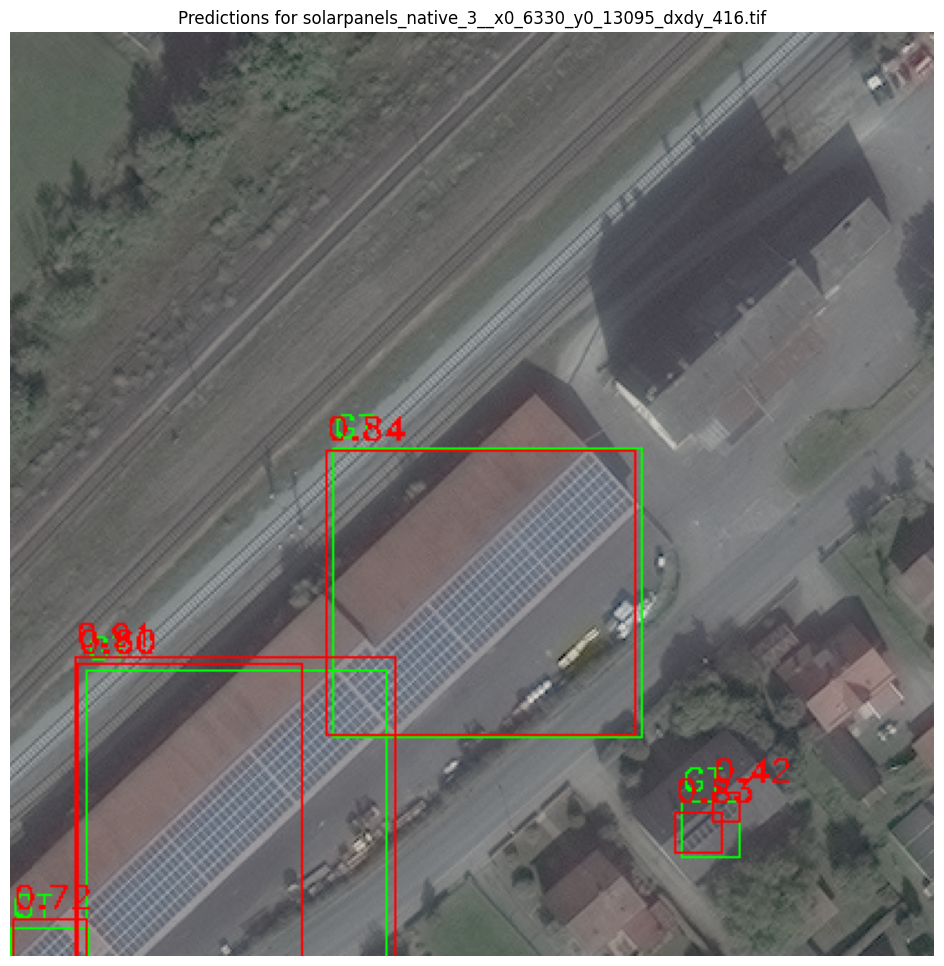


image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_5899_y0_13919_dxdy_416.tif: 416x416 3 items, 2.8ms
Speed: 0.4ms preprocess, 2.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


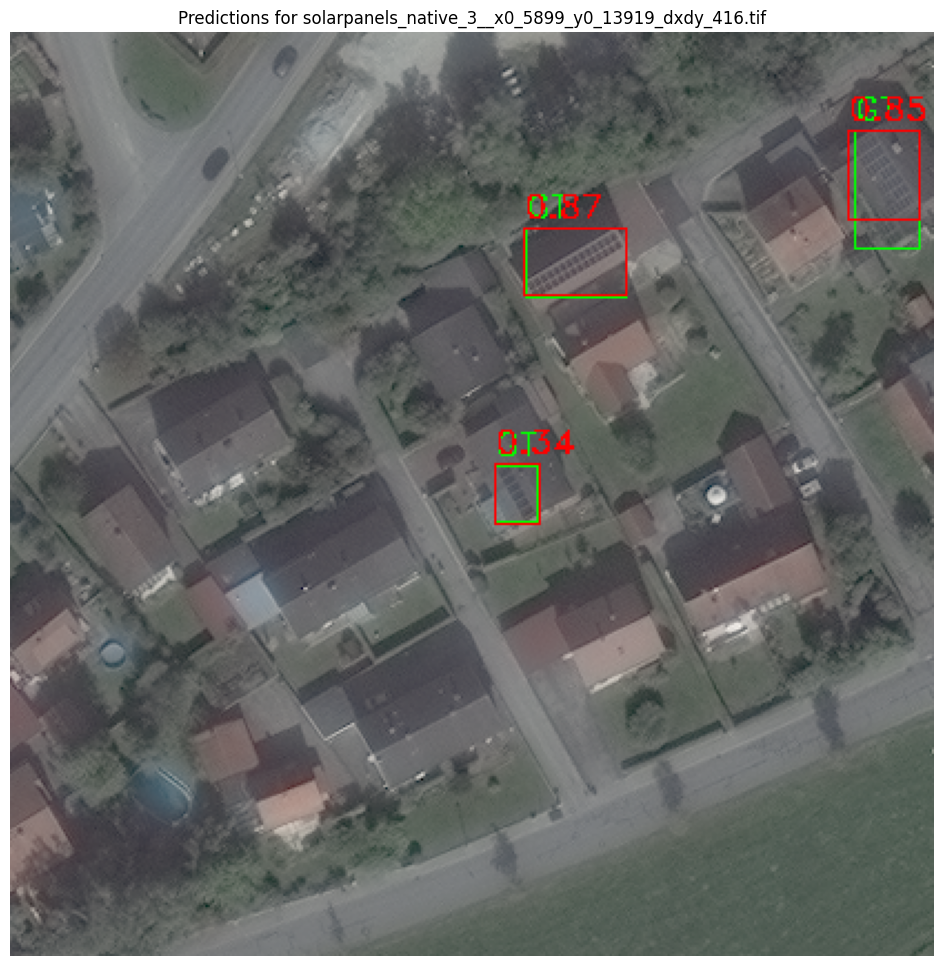


image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_9264_y0_12755_dxdy_416.tif: 416x416 2 items, 2.9ms
Speed: 0.4ms preprocess, 2.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


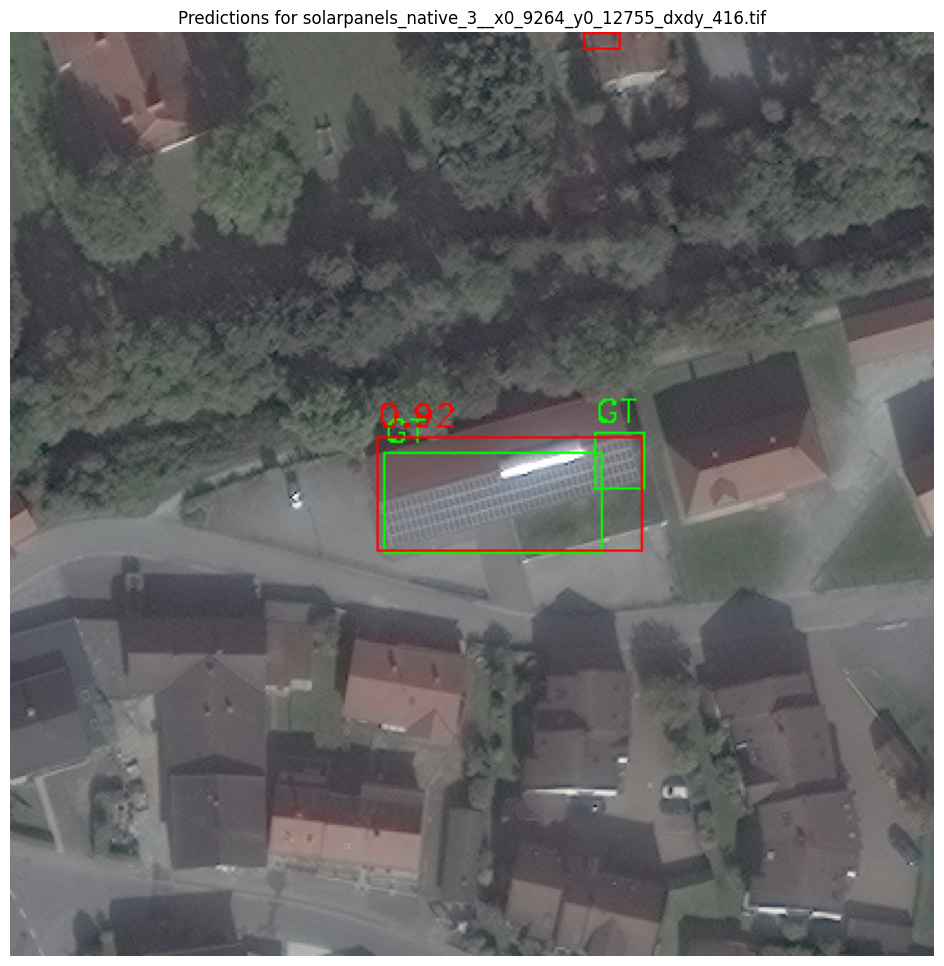


image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_8402_y0_9745_dxdy_416.tif: 416x416 6 items, 2.6ms
Speed: 0.4ms preprocess, 2.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


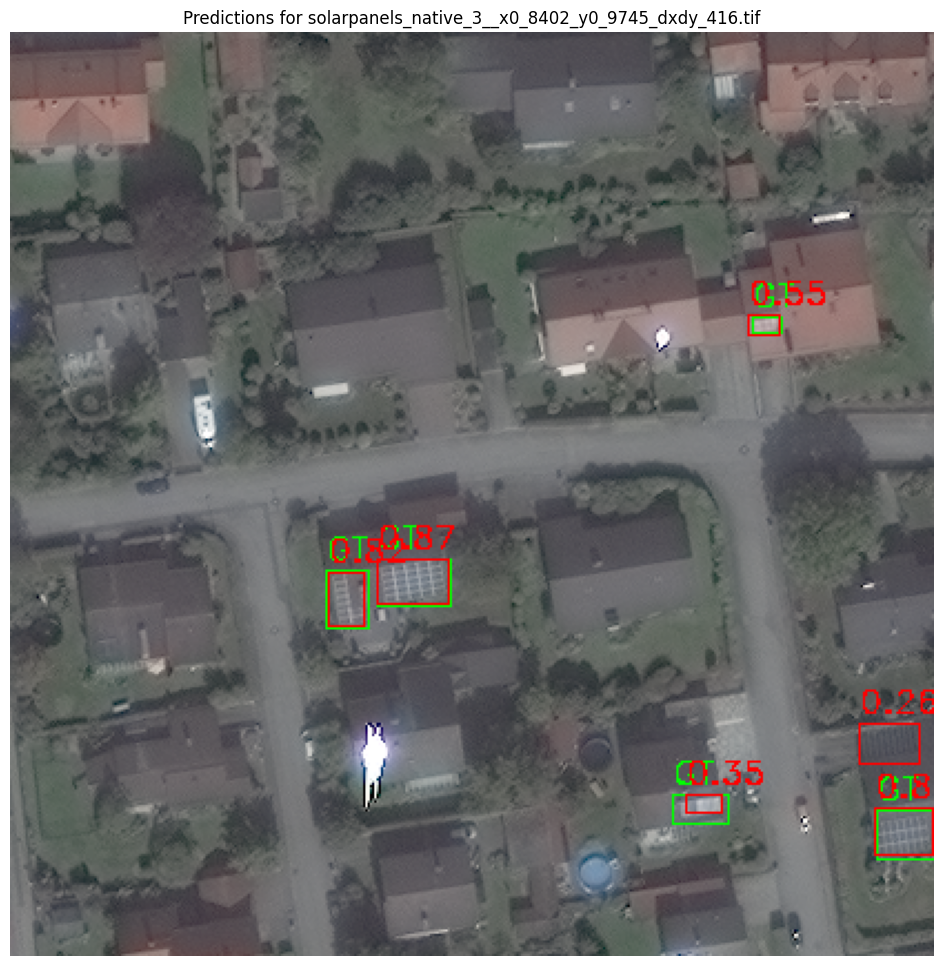


image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_8351_y0_15007_dxdy_416.tif: 416x416 6 items, 2.9ms
Speed: 0.4ms preprocess, 2.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


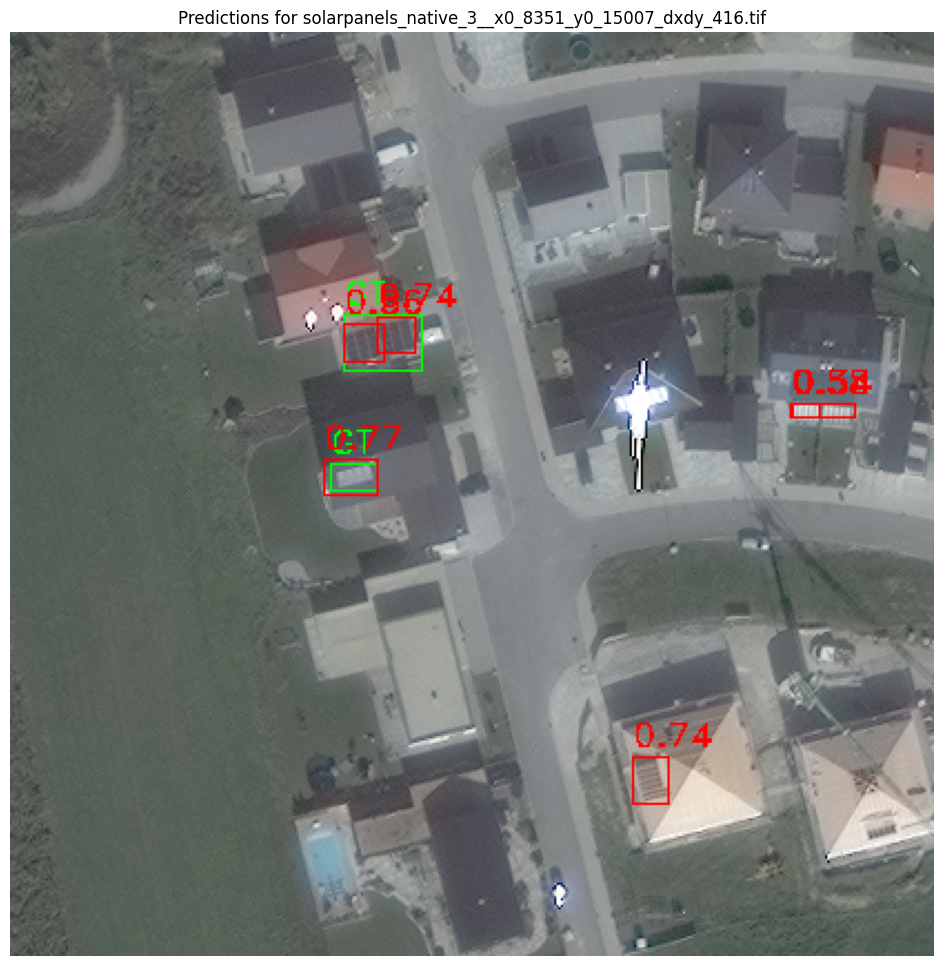

In [6]:
def load_ground_truth_boxes(label_path, img_width, img_height):
    boxes = []

    if not os.path.exists(label_path):
        return boxes
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            _, xc, yc, w, h = parts
            xc, yc, w, h = float(xc), float(yc), float(w), float(h)

            # int conversion since pixels should be integers
            x1 = int((xc - w / 2) * img_width)
            y1 = int((yc - h / 2) * img_height)
            x2 = int((xc + w / 2) * img_width)
            y2 = int((yc + h / 2) * img_height)
            boxes.append([x1, y1, x2, y2])

    return boxes

def draw_boxes(image_path, label_path, predictions, conf_thresh=0.25):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # ground truth boxes in green
    gt_boxes = load_ground_truth_boxes(label_path, w, h)
    for box in gt_boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cv2.putText(img, "GT", (x1, y1 - 5), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1)

    # process predictions
    # print(predictions)
    pred_result = predictions[0]

    if pred_result.boxes is not None:
        pred_boxes = pred_result.boxes.xyxy.cpu().numpy()
        pred_confs = pred_result.boxes.conf.cpu().numpy()
        for box, conf in zip(pred_boxes, pred_confs):
            if conf < conf_thresh:
                continue
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
            cv2.putText(img, f"{conf:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 0, 0), 1)

    return img

# define paths for test images and labels
DATA = os.path.join(os.getcwd(), "data")
test_images_dir = os.path.join(DATA, "test", "images")
test_labels_dir = os.path.join(DATA, "test", "labels")

test_images = [f for f in os.listdir(test_images_dir) if f.endswith('.tif')]
# randomly select 5 images
selected_files = random.sample(test_images, 5)

# visualize each selected image with predictions and ground truth
for file in selected_files:
    image_path = os.path.join(test_images_dir, file)
    label_path = os.path.join(test_labels_dir, file[:-4] + ".txt")
    
    # run prediction on the image using the trained model
    predictions = model.predict(source=image_path, conf=0.25)
    
    # visualize GT and predictions
    annotated_img = draw_boxes(image_path, label_path, predictions, conf_thresh=0.25)
    
    plt.figure(figsize=(12,12))
    plt.imshow(annotated_img)
    plt.title(f"Predictions for {file}")
    plt.axis("off")
    plt.show()

Note that in the above images, green boxes denote ground truth boxes and red boxes denote predictions along with confidence scores.

## 3. Use supervision.metrics functionality from supervision library to compute the following metrics.

### a. Compute mAP50 with supervision and compare with your implementation. What do you observe?

In [7]:
def predictions_to_detections(pred_result):
    boxes = pred_result.boxes.xyxy.cpu().numpy()
    conf = pred_result.boxes.conf.cpu().numpy()
    cls = pred_result.boxes.cls.cpu().numpy().astype(int)
    return sv.Detections(xyxy = boxes, confidence = conf, class_id = cls)

def xyxy_to_yolo(box):
    x1, y1, x2, y2 = box
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0
    w = x2 - x1
    h = y2 - y1
    return (x_center, y_center, w, h)

def yolo_to_xyxy(bbox):
    x, y, w, h = bbox
    return [x - w / 2, y - h / 2, x + w / 2, y + h / 2]

# calculating IoU with shapely
def iou_shapely(box1, box2):
    # box takes (minx, miny, maxx, maxy), so unpack the values from yolo format
    box1_xyxy = box(*yolo_to_xyxy(box1))
    box2_xyxy = box(*yolo_to_xyxy(box2))

    intersection = box1_xyxy.intersection(box2_xyxy).area
    union = box1_xyxy.union(box2_xyxy).area

    return intersection / union if union > 0 else 0

# calculating IoU with supervision
def iou_supervision(box1, box2):
    # box_iou_batch takes a batch of boxes as a numpy array
    box1_xyxy = np.array([yolo_to_xyxy(box1)])
    box2_xyxy = np.array([yolo_to_xyxy(box2)])

    return sv.box_iou_batch(box1_xyxy, box2_xyxy)[0][0]

def compute_pr(ground_truth_boxes, predicted_boxes, iou_threshold=0.5):
    ans = []
    gt_cnt = 0

    for ground_truth, predictions in zip(ground_truth_boxes, predicted_boxes):
        gt_cnt += len(ground_truth)
        matched = [False] * len(ground_truth)
        # sort all predictions in decreasing order of confidence
        sorted_predictions = sorted(predictions, key=lambda x: x[4], reverse=True)
        for prediction in sorted_predictions:
            pred = prediction[:4]
            max_iou, best_gt = -1, -1
            for i, gt in enumerate(ground_truth):
                if matched[i]:
                    continue # skip if already matched
                iou = iou_supervision(yolo_to_xyxy(pred), yolo_to_xyxy(gt))
                if iou > max_iou:
                    max_iou = iou
                    best_gt = i
            if max_iou >= iou_threshold and best_gt != -1: # match if best and IoU > threshold
                matched[best_gt] = True
                ans.append([prediction[4], 1]) # 1 means true positive
            else:
                ans.append([prediction[4], 0]) # 0 means false positive

    ans = sorted(ans, key=lambda x: x[0], reverse=True)
    
    tp = np.array([x[1] for x in ans])

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(1 - tp)
    recalls = cum_tp / gt_cnt # recall = TP / (TP + FN) = TP / total ground truths
    precisions = cum_tp / (cum_tp + cum_fp) # precision = TP / (TP + FP) = TP / total predictions

    return recalls, precisions

def pascal_voc_ap(recalls, precisions):
    ap = 0
    for t in np.linspace(0, 1, 11):
        ap += np.max(precisions[recalls >= t]) if len(precisions[recalls >= t]) > 0 else 0
    return ap / np.float32(11)

def coco_ap(recalls, precisions):
    ap = 0
    for t in np.linspace(0, 1, 101):
        ap += np.max(precisions[recalls >= t]) if len(precisions[recalls >= t]) > 0 else 0
    return ap / np.float32(101)

def area_under_curve(recalls, precisions):
    return auc(recalls, precisions)

map_metric = MeanAveragePrecision()

custom_gt_boxes = []
custom_pred_boxes = []

for file in test_images:
    image_path = os.path.join(test_images_dir, file)
    label_path = os.path.join(test_labels_dir, file[:-4] + ".txt")
    
    img = cv2.imread(image_path)
    if img is None:
        continue
    h, w, _ = img.shape
    
    # converting to Supervision Detections format
    gt_boxes_abs = load_ground_truth_boxes(label_path, w, h)
    gt_dets = sv.Detections(
        xyxy=np.array(gt_boxes_abs, dtype=np.float32),
        class_id=np.zeros((len(gt_boxes_abs),), dtype=int),
        confidence=np.ones((len(gt_boxes_abs),), dtype=np.float32)
    )

    # generating prediction for current image
    preds = model.predict(source=image_path, conf=0.3)
    pred_boxes_abs = preds[0].boxes.xyxy.cpu().numpy()
    confs = preds[0].boxes.conf.cpu().numpy()
    cls = preds[0].boxes.cls.cpu().numpy().astype(int)
    pred_dets = sv.Detections(xyxy=pred_boxes_abs, confidence=confs, class_id=cls)
    
    map_metric.update(pred_dets, gt_dets)
    
    # converting ground truth to absolute yolo format
    gt_yolo = [xyxy_to_yolo(box) for box in gt_boxes_abs]
    custom_gt_boxes.append(gt_yolo)
    
    # converting predicted boxes from absolute xyxy to absolute yolo format
    pred_yolo = []
    for box, conf in zip(pred_boxes_abs, confs):
        yolo_box = xyxy_to_yolo(box)
        pred_yolo.append(yolo_box + (conf,))
    
    custom_pred_boxes.append(pred_yolo)

map_result = map_metric.compute()
supervision_map50 = map_result.map50
print("mAP50 with supervision:", supervision_map50)

# custom mAP50
recalls, precisions = compute_pr(custom_gt_boxes, custom_pred_boxes, iou_threshold=0.5)
custom_map50_pascal = pascal_voc_ap(recalls, precisions)
custom_map50_coco = coco_ap(recalls, precisions)
custom_map50_auc = area_under_curve(recalls, precisions)

print("Custom mAP50 (Pascal VOC 11-point method):", custom_map50_pascal)
print("Custom mAP50 (COCO 101-point method):", custom_map50_coco)
print("Custom mAP50 (AUC method):", custom_map50_auc)


image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_6833_y0_12963_dxdy_416.tif: 416x416 8 items, 4.9ms
Speed: 0.6ms preprocess, 4.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_8532_y0_14457_dxdy_416.tif: 416x416 6 items, 6.5ms
Speed: 0.6ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_5151_y0_12340_dxdy_416.tif: 416x416 7 items, 7.2ms
Speed: 0.8ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_6082_y0_11378_dxdy_416.tif: 416x416 3 items, 7.0ms
Speed: 0.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/nishuz/

The mAP50 computed using the supervision library gives a value of 0.6551, while our custom implementations using different interpolation methods yield slightly higher values: 0.7089 for Pascal VOC 11-point interpolation, 0.7472 for COCO 101-point interpolation, and 0.7454 for the AUC method. These differences probably arise due to variations in how precision-recall curves are interpolated and integrated. The COCO 101-point and AUC methods tend to provide higher estimates since they capture more detailed precision values across recall levels, whereas the Pascal VOC method uses fewer interpolation points.

### b. Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1) 


image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_6833_y0_12963_dxdy_416.tif: 416x416 11 items, 8.6ms
Speed: 1.2ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_8532_y0_14457_dxdy_416.tif: 416x416 8 items, 6.9ms
Speed: 0.7ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_5151_y0_12340_dxdy_416.tif: 416x416 8 items, 6.6ms
Speed: 0.7ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/nishuz/Desktop/College/SRIP/Selection/data/test/images/solarpanels_native_3__x0_6082_y0_11378_dxdy_416.tif: 416x416 6 items, 7.2ms
Speed: 0.8ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/nishuz

IoU_threshold  Confidence_threshold  Precision    Recall        F1
0             0.1                   0.1   0.670435  0.831940  0.742507
1             0.1                   0.3   0.800187  0.767463  0.783483
2             0.1                   0.5   0.872396  0.700000  0.776747
3             0.1                   0.7   0.939898  0.606866  0.737529
4             0.1                   0.9   0.998538  0.203881  0.338622
5             0.3                   0.1   0.660091  0.819104  0.731051
6             0.3                   0.3   0.787737  0.755522  0.771294
7             0.3                   0.5   0.859747  0.689851  0.765485
8             0.3                   0.7   0.928340  0.599403  0.728460
9             0.3                   0.9   0.991228  0.202388  0.336143
10            0.5                   0.1   0.621602  0.771343  0.688424
11            0.5                   0.3   0.746654  0.716119  0.731068
12            0.5                   0.5   0.818080  0.656418  0.728387
13            0.5                   0.7   0.892742  0.576418  0.700526
14            0.5                   0.9   0.980994  0.200299  0.332672
15            0.7                   0.1   0.524417  0.650746  0.580791
16            0.7                   0.3   0.644880  0.618507  0.631419
17            0.7                   0.5   0.729167  0.585075  0.649222
18            0.7                   0.7   0.818308  0.528358  0.642119
19            0.7                   0.9   0.966374  0.197313  0.327714
20            0.9                   0.1   0.140005  0.173731  0.155055
21            0.9                   0.3   0.178960  0.171642  0.175225
22            0.9                   0.5   0.211310  0.169552  0.188142
23            0.9                   0.7   0.252427  0.162985  0.198077
24            0.9                   0.9   0.494152  0.100896  0.167576

F1-score Table:


Confidence_threshold       0.1       0.3       0.5       0.7       0.9
IoU_threshold                                                         
0.1                   0.742507  0.783483  0.776747  0.737529  0.338622
0.3                   0.731051  0.771294  0.765485  0.728460  0.336143
0.5                   0.688424  0.731068  0.728387  0.700526  0.332672
0.7                   0.580791  0.631419  0.649222  0.642119  0.327714
0.9                   0.155055  0.175225  0.188142  0.198077  0.167576

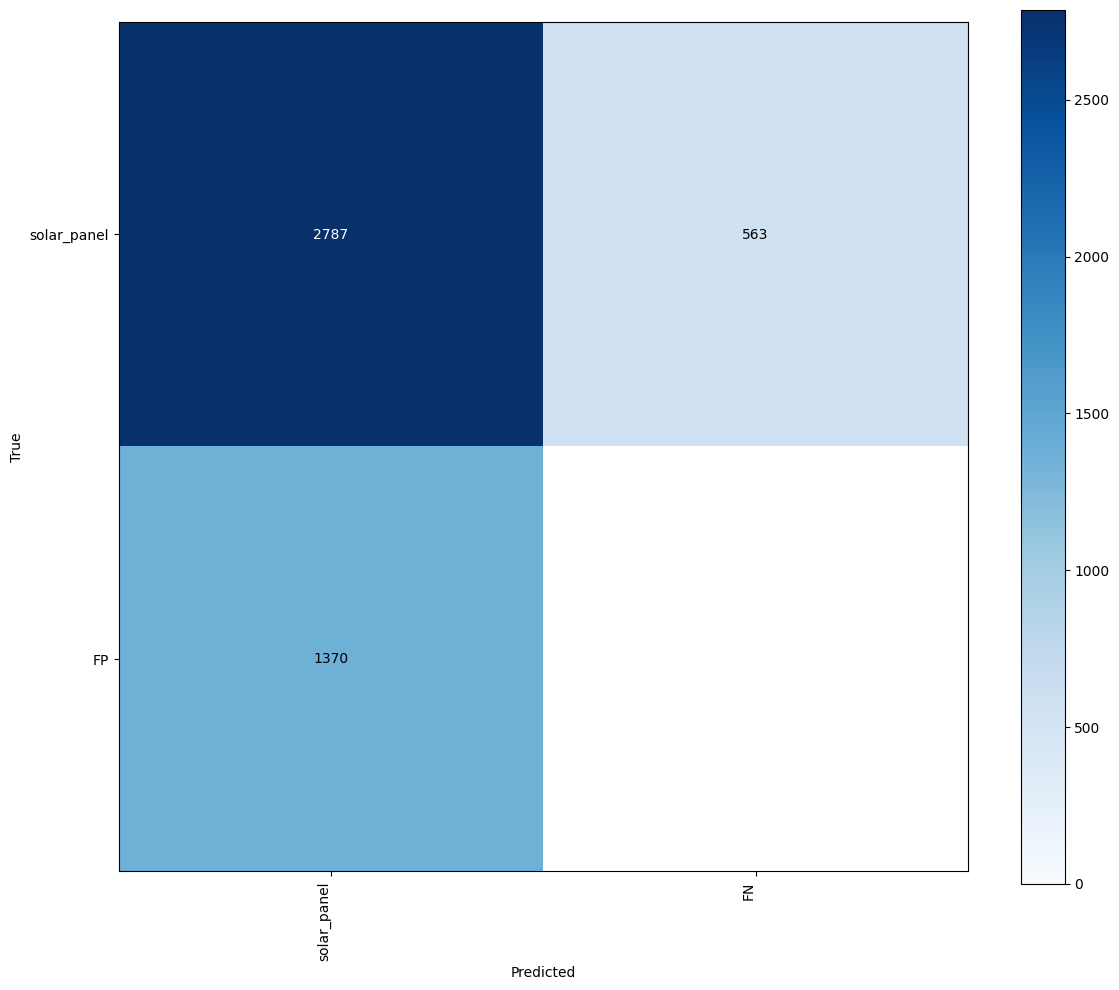

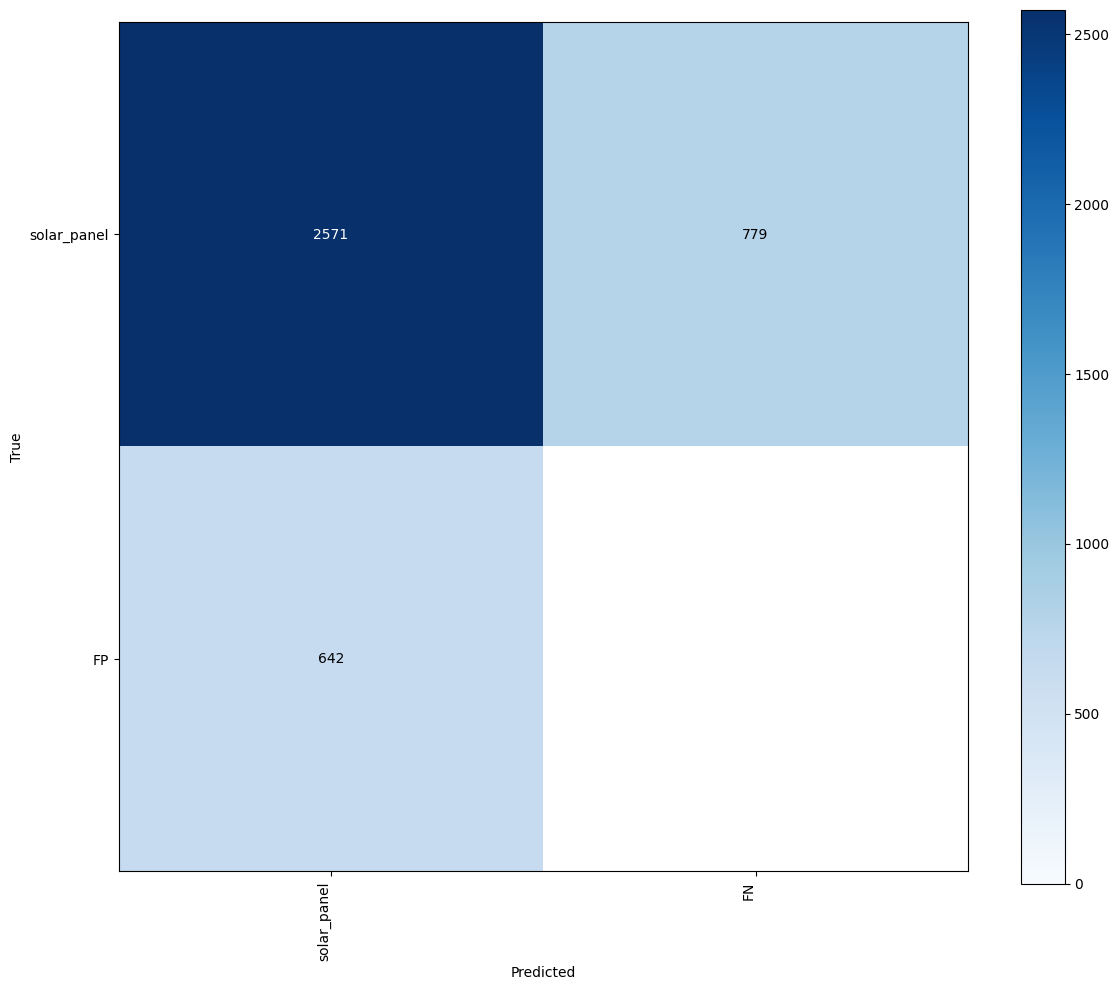

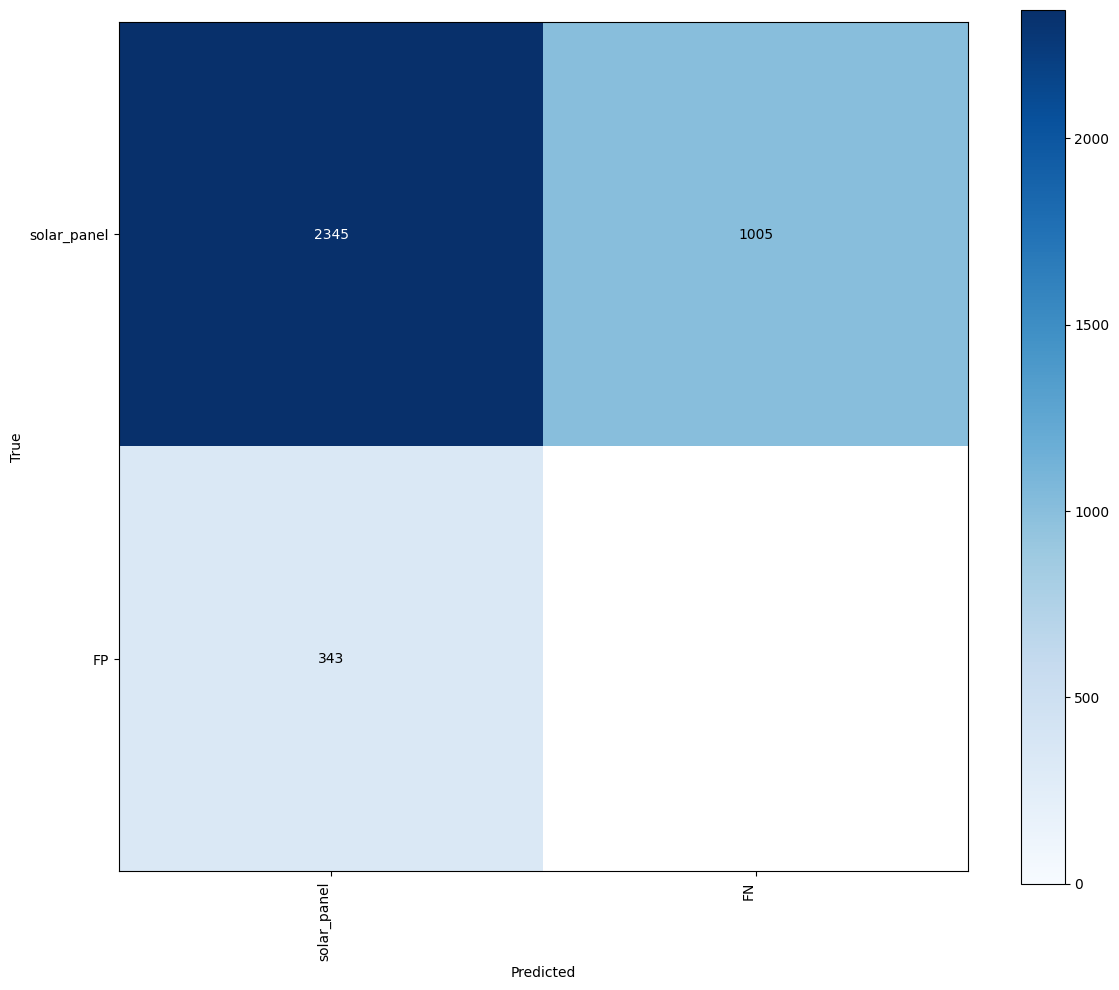

In [8]:
def load_ground_truth_boxes_float(label_path, img_width, img_height):
    boxes = []
    if not os.path.exists(label_path):
        return np.empty((0,5), dtype=np.float32)
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            _, xc, yc, bw, bh = parts
            xc, yc, bw, bh = float(xc), float(yc), float(bw), float(bh)
            x1 = (xc - bw / 2) * img_width
            y1 = (yc - bh / 2) * img_height
            x2 = (xc + bw / 2) * img_width
            y2 = (yc + bh / 2) * img_height
            boxes.append([x1, y1, x2, y2, 0])
    
    return np.array(boxes, dtype=np.float32)

def predictions_to_tensor(pred_result):
    if pred_result.boxes is None:
        return np.empty((0, 6), dtype=np.float32)
    boxes = pred_result.boxes.xyxy.cpu().numpy()
    confs = pred_result.boxes.conf.cpu().numpy()
    cls_arr = pred_result.boxes.cls.cpu().numpy().astype(int)
    cls_arr[:] = 0 # only one class (0)
    # tensor of schema [x1, y1, x2, y2, class, confidence]
    return np.column_stack([boxes, cls_arr, confs])

predictions_tensors = []
targets_tensors = []

for file in test_images:
    image_path = os.path.join(test_images_dir, file)
    label_path = os.path.join(test_labels_dir, file[:-4] + ".txt")
    
    h, w = float(416), float(416)

    # load ground truth boxes (absolute xyxy, with class appended)
    targets_abs = load_ground_truth_boxes_float(label_path, w, h)
    targets_tensors.append(targets_abs)
    
    # Run prediction with a low threshold to capture all detections.
    preds = model.predict(source=image_path, conf=0.1)
    pred_tensor_abs = predictions_to_tensor(preds[0])
    predictions_tensors.append(pred_tensor_abs)

iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

results_list = []

plot_cnt = 3

for iou_thr in iou_thresholds:
    for conf_thr in conf_thresholds:
        # building the confusion matrix with the given thresholds
        cm = sv.ConfusionMatrix.from_tensors(
            predictions=predictions_tensors,
            targets=targets_tensors,
            classes=["solar_panel"],
            conf_threshold=conf_thr,
            iou_threshold=iou_thr
        )

        print(cm.matrix)
        if plot_cnt > 0:
            cm.plot()
            plot_cnt -= 1
        
        TP = cm.matrix[0, 0]
        FP = cm.matrix[1, 0]
        FN = cm.matrix[0, 1]
        TN = cm.matrix[1, 1]

        # metrics
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        results_list.append({
            "IoU_threshold": iou_thr,
            "Confidence_threshold": conf_thr,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        })

df_metrics = pd.DataFrame(results_list)
print("Metrics Table:")
display(df_metrics)

df_f1 = df_metrics.pivot(index="IoU_threshold", columns="Confidence_threshold", values="F1")
print("F1-score Table:")
display(df_f1)